<a href="https://colab.research.google.com/github/SC1DR-OFFICIAL/GAN-MNIST-Fashion/blob/main/GAN_MNIST_Fashion_RU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи

**Цель:** сравнить две разные архитектуры DCGAN (классическую и улучшенную) на задаче генерации изображений одежды из набора Fashion-MNIST. Сделать выводы об их эффективности.

**План действий:**
1. Загрузить и подготовить датасет Fashion-MNIST
2. Реализовать обе модели генератора и дискриминатора.
3. Обучить обе GAN-модели (поочерёдно) на одном и том же датасете:
   - Использовать одинаковый размер латентного вектора.
   - Использовать одинаковое количество эпох.
   - Использовать одинаковые параметры обучения.
4. Провести **сравнительный анализ** результатов
5. Сделать **выводы** — какая архитектура обучалась быстрее, генерирует более реалистичные изображения, имеет лучшую стабильность.

# 1. Загрузка датасета Fashion-MNIST

Импорт библиотек

In [ ]:
# Работа с изображениями
from PIL import Image
import imageio
import cv2
from keras.preprocessing.image import img_to_array

# Библиотека линейной алгебры
import numpy as np

# Работа с файловой системой и системными функциями
import os

# Подготовка данных
from keras import preprocessing
import tensorflow as tf

# Построение сети
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape

# Визуализация выполнения процессов, циклов
from tqdm import tqdm

# Генерация случайных чисел
import re

# Работа с графиками
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Отключаем лишние предупреждения
import warnings
warnings.filterwarnings('ignore')

Загрузка датасета Fashion MNIST

In [ ]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

Проверим размеры изображений

In [ ]:
print("Форма train_images:", train_images.shape)
print("Тип данных:", train_images.dtype)

Форма train_images: (60000, 28, 28)
Тип данных: uint8


Определим переменные для нашей модели и входных изображений

In [ ]:
SIZE = 28                     # размер изображения по одному измерению
INPUT_IMG = (SIZE, SIZE, 1)   # чёрно-белое изображение → 1 канал
BATCH_SIZE = 32               # размер пакета для обучения
LATENT_DIM = 100              # размерность латентного пространства
EPOCHS = 50

Загрузим изображения в тензор, предварительно преобразовав к диапазону $[-1, 1]$, так как мы будем использовать функцию активации `tanh` на выходном слое генератора.

In [ ]:
images = []
for img in train_images:
    # Не переводим в RGB — оставляем 1 канал
    img_pil = Image.fromarray(img)

    # Опционально: ресайз (если SIZE ≠ 28)
    if SIZE != 28:
        img_pil = img_pil.resize((SIZE, SIZE))

    # Преобразуем в массив float32 и нормализуем в [-1, 1]
    img_array = np.array(img_pil).astype(np.float32)
    img_array = (img_array - 127.5) / 127.5

    # Добавляем размерность канала: (H, W) → (H, W, 1)
    img_array = np.expand_dims(img_array, axis=-1)

    images.append(img_array)

X_train = np.array(images)

Сгенерируем датасет с разбивкой по батчам из тензора изображений NumPy. Использование класса `Dataset`, позволяет фреймворку Keras (а точнее Tensorflow, как его бекэнду), оптимизировать вычисления, экономя в первую очередь оперативную память.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)

### Визуализация данных

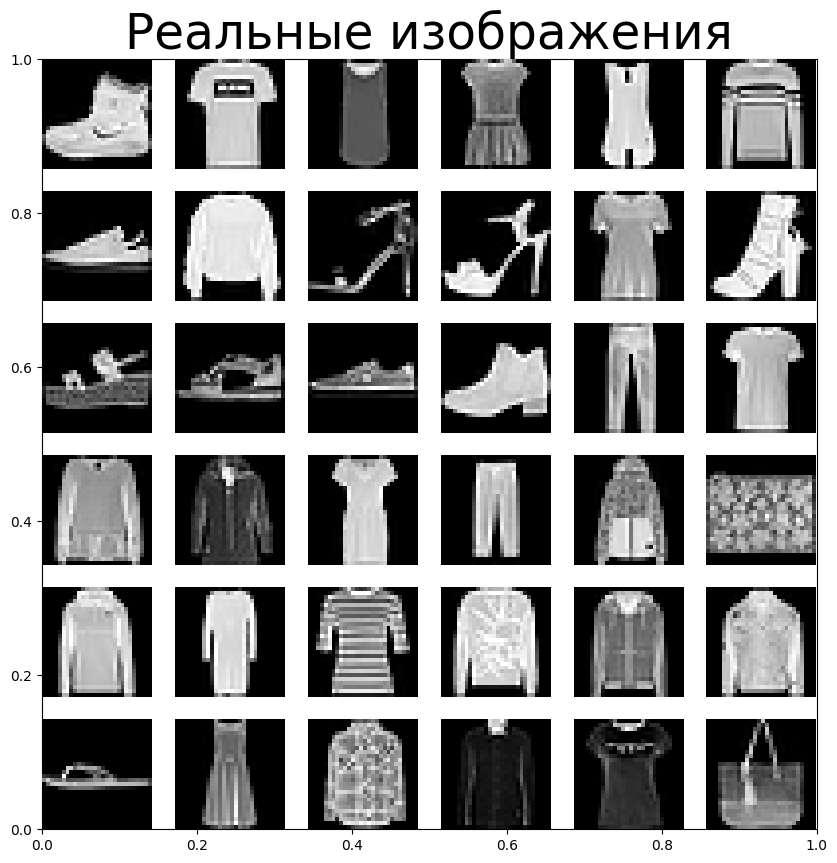

In [ ]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Реальные изображения", fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(X_train[i]*0.5 + 0.5, cmap="gray")
        plt.axis('off')

# to plot images
plot_images(6)

# 2. Архитектура модели

Архитектура модели состоит из генератора и дискриминатора.

## 2.1 Классический DCGAN



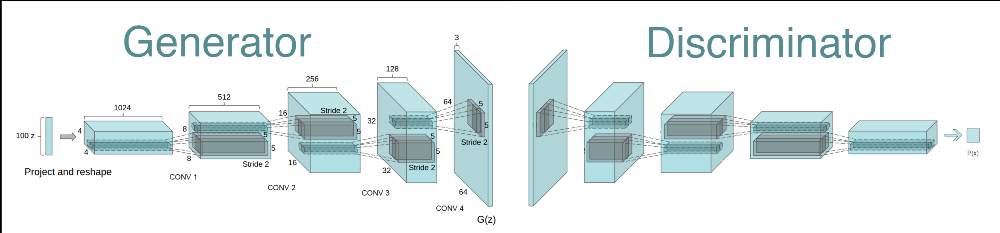

DCGAN (Deep Convolutional GAN) состоит из двух основных компонентов:

* Генератор (Generator) — создает изображения из случайного шума.
* Дискриминатор (Discriminator) — определяет, являются ли изображения подлинными или сгенерированными.

**Классический DCGAN** строит изображение из вектора шума размером (100,) путём последовательного увеличения разрешения через слои `Conv2DTranspose`. Архитектура линейна, направлена строго снизу вверх: от низкого разрешения (4×4) до финального (28×28×1). Это делает структуру простой и эффективной, но с ограниченной способностью к восстановлению сложных деталей.


#### Генератор

In [ ]:
def GeneratorClassic():
    model = Sequential()

    # 7x7x128 — сразу приближаемся к 28x28, чтобы сделать 2 апсемплинга
    model.add(tf.keras.layers.Dense(7*7*128, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(tf.keras.layers.Reshape((7, 7, 128)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # 14x14x64
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())

    # 28x28x1
    model.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh'))

    return model

In [ ]:
generator_classic = GeneratorClassic()
generator_classic.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,369 (3.18 MB)

 Trainable params: 833,985 (3.18 MB)

 Non-trainable params: 384 (1.50 KB)

#### Дискриминатор

In [ ]:
def DiscriminatorClassic():
    model = Sequential()

    # 28x28x1 → 14x14x64
    model.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    # 14x14x64 → 7x7x128
    model.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.3))

    # 7x7x128 → flat → 1
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator_classic = DiscriminatorClassic()
discriminator_classic.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Улучшенный DCGAN

**Улучшенный GAN** использует более глубокую архитектуру, включающую как понижающую (`Conv2D` с `strides=2`), так и повышающую (`Conv2DTranspose`) дискретизацию. На входе создаётся сразу изображение 28×28×1, которое сжимается и затем восстанавливается, напоминая автокодировщик. Это позволяет модели лучше улавливать глобальные и локальные паттерны, что особенно полезно при генерации сложных структур, таких как элементы одежды.


#### Генератор

In [ ]:
def GeneratorImproved():
    model = Sequential()

    # Начинаем с тензора 7x7x128 (как у DCGAN, но с down→up)
    model.add(Dense(7*7*128, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(Reshape((7, 7, 128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Понижающая дискретизация (условно — работает как свёртка признаков)
    model.add(Conv2D(128, 3, strides=1, padding='same', use_bias=False, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, 3, strides=1, padding='same', use_bias=False, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Повышающая дискретизация до 14x14
    model.add(Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # До 28x28
    model.add(Conv2DTranspose(32, 4, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Выходной слой: 28x28x1
    model.add(Conv2DTranspose(1, 3, strides=1, padding='same', activation='tanh'))

    return model

В свертках мы используем инициализацию весов `kernel_initializer='he_normal'` и не используем смещения `use_bias=False`. Такая инициализация весов является общепринятой для задач машинного зрения, веса получают значения близкие к нулю  и нормально распределены их значения, за подробностями можно обратиться к в оригинальной [статье](https://arxiv.org/pdf/1502.01852). Обратите внимание, что `he_normal` - это составное название инициализатора: `He` - фамилия автора, а `normal` указывает на нормальное распределение.

In [ ]:
generator_improved = GeneratorImproved()
generator_improved.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 64)       │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 14, 14, 64)     │        65,536 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 948,641 (3.62 MB)

 Trainable params: 947,809 (3.62 MB)

 Non-trainable params: 832 (3.25 KB)

#### Дискриминатор

Модель дискриминатора использует изображения размером 28 на 28 на 1, которые могут быть реальными или сгенерированными. Входное изображение подвергается понижающей дискретизации с использованием слоя свертки `Conv2D` и, наконец, выравнивается с помощью слоя `Flatten` и передается на один нейрон, чтобы он смог отличить реальное изображение от поддельного. Поскольку последний слой использует сигмоидную функцию в качестве активации, он выдает значение в диапазоне от 0 до 1. Здесь значение больше 0,5 относится к реальному изображению, а меньше 0,5 - к поддельному. Выходные данные дискриминатора используются при обучении генератора.

In [ ]:
def DiscriminatorImproved():
    model = Sequential()

    # 28x28x1 → 14x14x64
    model.add(Conv2D(64, 4, strides=2, padding='same', input_shape=(28, 28, 1),
                     kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # 14x14x64 → 7x7x128
    model.add(Conv2D(128, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # 7x7x128 → 4x4x256
    model.add(Conv2D(256, 4, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    # Flatten and output
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator_improved = DiscriminatorImproved()
discriminator_improved.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 128)      │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 670,721 (2.56 MB)

 Trainable params: 669,825 (2.56 MB)

 Non-trainable params: 896 (3.50 KB)

Давайте построим изображение, сгенерированное генератором перед обучением.

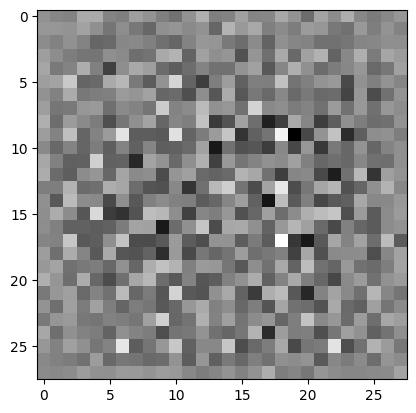

In [ ]:
noise = np.random.normal(-1,1,(1,LATENT_DIM))
img = generator_improved(noise)
plt.imshow(img[0,:,:,0], cmap="gray")
plt.show()

Необученный генератор создает из шума новый шум!

# 3. Обучение моделей

## Определение функции потерь и оптимизатора

Далее необходимо определить функцию потерь и оптимизаторы для генератора и дискриминатора.

**ВАЖНО:** необходимо отдельно определить оптимизаторы для генератора и дискриминатора. Несмотря на то, что они идентичны, использование общего оптимизатора приведет к ошибке в процессе обучения.

В качестве оптимизатора мы будем использовать `Adam` c параметрами `learning_rate=0.0002` и `beta_1=0.5`. В качестве функции ошибки - бинарную кросс-энтропию.

In [ ]:
optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Этот метод возвращает вспомогательную функцию для вычисления перекрестных потерь энтропии
cross_entropy = tf.keras.losses.BinaryCrossentropy()

На основе бинарной кросс-энтропии определим функцию потерь для дискриминатора. Эта функция должна количественно определять, насколько хорошо дискриминатор способен отличать настоящие изображения от подделок. Он сравнивает предсказания дискриминатора для реальных изображений с массивом единиц (той же формы, что и изображение), а предсказания дискриминатора для поддельных (сгенерированных) изображений — с массивом нулей (той же формы, что и изображение). Полученные ошибки сравнения суммируются.

In [ ]:
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    return fake_loss + real_loss

Что касается функции потерь генератора, то здесь все проще. Функция потерь генератора количественно определяет, насколько хорошо он смог обмануть дискриминатор. Интуитивно понятно, что если генератор работает хорошо, дискриминатор классифицирует поддельные изображения как настоящие (равные единице). Поэтому функция ошибки для дискриминатора возвращает ошибку бинарной кросс-энтропии от сравнения фейкового изображения с единицей (единичной матрицей).

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Обучение классической модели DCGAN

Определим один шаг обучения. Цикл обучения начинается с того, что генератор получает на вход случайный шум, который используется для создания изображения. Затем дискриминатор используется для классификации реальных изображений (извлеченных из обучающего набора) и поддельных изображений (созданных генератором). Потери рассчитываются для каждой из этих моделей, а градиенты используются для обновления генератора и дискриминатора.



Для обучения одновременно генератора и дискриминатора нам нужен более низкий уровень для циклов обучения и оценки, чем тот что дают `fit()` и `evaluate()`, поэтому придется писать свои собственные. На самом деле это довольно просто! Но необходимо приготовиться к большему количеству отладки.

Обучение на низком уровне сопряжено с вычислением градиентов, которое выполняется с использованием `GradientTape`.

Вызов модели внутри области видимости `GradientTape` позволяет получить градиенты обучаемых весов слоя относительно значения потерь. Используя экземпляр оптимизатора, мы будем использовать эти градиенты для обновления весов модели.

Используем мини-пакетный градиентный спуск с кастомным циклом обучения. Подробности в комментарии к коду.

In [ ]:
# Мы используем декоратор `tf.function`, можно и без него
# Он указывает на то, что функция должна быть скомпилирована, что оптимизирует процесс обучения.
@tf.function
def train_steps(images):

    # генерируем шум на входе генератора
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Инициализируем GradientTape (градиентную ленту) для дискриминатора и генератор
    #  по отдельности, чтобы записать операции,
    # выполняемые во время прямого прохода, включающего автодифференцирование.
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        # Запустим прямой проход шума через генератор.
        # Операции применяемые каждым слоем к своим
        # входным данным будут записаны на GradientTape, как на ленту магнитофона.
        # Отсюда и название градиентной ленты.
        generated_images = generator_classic(noise)

        # Также обеспечиваем прямой проход через дискриминатор для
        # для реальных и фейковых изображений
        fake_output = discriminator_classic(generated_images)
        real_output = discriminator_classic(images)

        # расчитываем функции ошибок (значения потерь)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Используем gradient tape для автоматического извлечения градиентов
    # обучаемых переменных относительно потерь.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator_classic.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator_classic.trainable_variables)

    # Выполним один шаг градиентного спуска, обновив
    # значение переменных минимизирующих потери.
    optimizer_G.apply_gradients(zip(gradient_of_generator,generator_classic.trainable_variables))
    optimizer_D.apply_gradients(zip(gradient_of_discriminator, discriminator_classic.trainable_variables))

    # Вернем значения потерь для визуализации
    loss = {'gen_loss':gen_loss,
           'disc_loss': dis_loss}
    return loss

Далее напишем функцию `train()`, которая запускает цикл обучения для каждой эпохи. Генератор и дискриминатор должны обучаться одновременного, при этом не подавляя друг друга, поэтому важно, чтобы они обучались с одной и той же скоростью.

In [ ]:
import time
def train(epochs, dataset):
    D_loss=[] # список для сбора значений потерь для дискриминатора
    G_loss=[] # список для сбора значений потерь для генератора
    for epoch in range(epochs):
        start = time.time()
        print("\nЭпоха : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Время:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'],loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

In [ ]:
G_classic, D_classic = train(EPOCHS, dataset)


Эпоха : 1
 Время:11.0
Generator Loss: 0.6502019166946411 Discriminator Loss: 1.3852556943893433

Эпоха : 2
 Время:9.0
Generator Loss: 0.7201904058456421 Discriminator Loss: 1.3628164529800415

Эпоха : 3
 Время:9.0
Generator Loss: 0.728728175163269 Discriminator Loss: 1.3791000843048096

Эпоха : 4
 Время:9.0
Generator Loss: 0.7200323939323425 Discriminator Loss: 1.356016993522644

Эпоха : 5
 Время:9.0
Generator Loss: 0.7388072609901428 Discriminator Loss: 1.3578788042068481

Эпоха : 6
 Время:9.0
Generator Loss: 0.7771390080451965 Discriminator Loss: 1.3432176113128662

Эпоха : 7
 Время:9.0
Generator Loss: 0.8024815320968628 Discriminator Loss: 1.409387469291687

Эпоха : 8
 Время:9.0
Generator Loss: 0.7746063470840454 Discriminator Loss: 1.210113286972046

Эпоха : 9
 Время:9.0
Generator Loss: 0.873432993888855 Discriminator Loss: 1.2900209426879883

Эпоха : 10
 Время:9.0
Generator Loss: 0.9958521723747253 Discriminator Loss: 1.075045108795166

Эпоха : 11
 Время:9.0
Generator Loss: 1.629

# Генерация изображений с помощью классической модели DCGAN

In [ ]:
def plot_generated_images(square = 5):


  plt.figure(figsize = (10,10))
  for i in range(square * square):
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,LATENT_DIM))
    img = generator_classic(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap="gray")

    plt.axis('off')
    plt.grid()

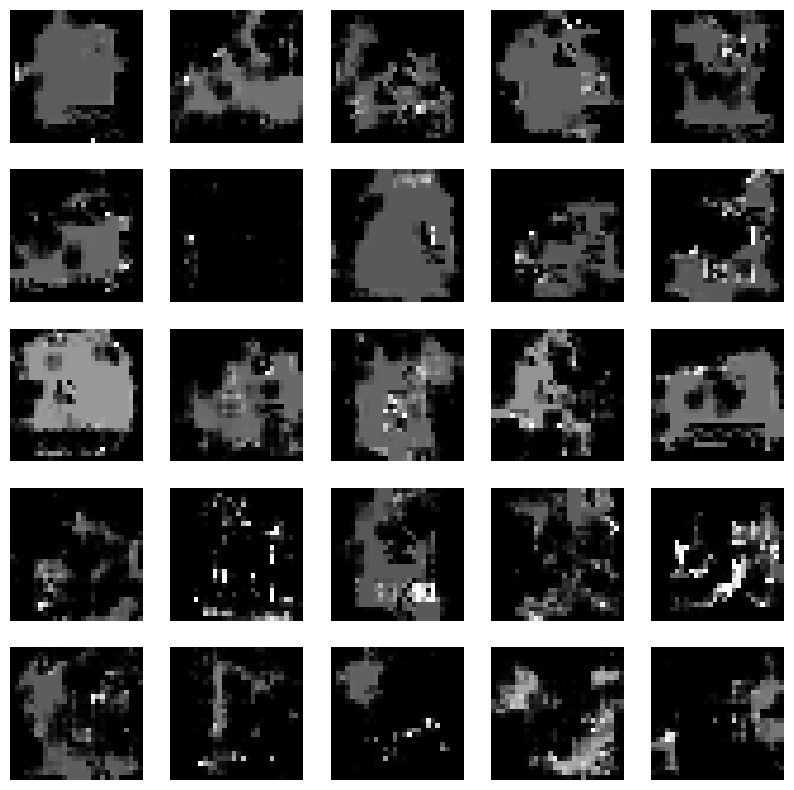

In [ ]:
plot_generated_images(5)

## Обучение улучшенной модели DCGAN

In [ ]:
optimizer_G_improved = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_D_improved = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Этот метод возвращает вспомогательную функцию для вычисления перекрестных потерь энтропии
cross_entropy_improved = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Мы используем декоратор `tf.function`, можно и без него
# Он указывает на то, что функция должна быть скомпилирована, что оптимизирует процесс обучения.
@tf.function
def train_steps_improved(images):

    # генерируем шум на входе генератора
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))

    # Инициализируем GradientTape (градиентную ленту) для дискриминатора и генератор
    #  по отдельности, чтобы записать операции,
    # выполняемые во время прямого прохода, включающего автодифференцирование.
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        # Запустим прямой проход шума через генератор.
        # Операции применяемые каждым слоем к своим
        # входным данным будут записаны на GradientTape, как на ленту магнитофона.
        # Отсюда и название градиентной ленты.
        generated_images = generator_improved(noise)

        # Также обеспечиваем прямой проход через дискриминатор для
        # для реальных и фейковых изображений
        fake_output = discriminator_improved(generated_images)
        real_output = discriminator_improved(images)

        # расчитываем функции ошибок (значения потерь)
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)

    # Используем gradient tape для автоматического извлечения градиентов
    # обучаемых переменных относительно потерь.
    gradient_of_generator = gen_tape.gradient(gen_loss, generator_improved.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator_improved.trainable_variables)

    # Выполним один шаг градиентного спуска, обновив
    # значение переменных минимизирующих потери.
    optimizer_G_improved.apply_gradients(zip(gradient_of_generator,generator_improved.trainable_variables))
    optimizer_D_improved.apply_gradients(zip(gradient_of_discriminator, discriminator_improved.trainable_variables))

    # Вернем значения потерь для визуализации
    loss = {'gen_loss':gen_loss,
           'disc_loss': dis_loss}
    return loss

In [ ]:
import time
def train_improved(epochs, dataset):
    D_loss=[] # список для сбора значений потерь для дискриминатора
    G_loss=[] # список для сбора значений потерь для генератора
    for epoch in range(epochs):
        start = time.time()
        print("\nЭпоха : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps_improved(images)
        print(" Время:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen_loss'],loss['disc_loss']))
        D_loss.append(loss['disc_loss'])
        G_loss.append(loss['gen_loss'])
    return (G_loss, D_loss)

In [ ]:
G_improved, D_improved = train_improved(EPOCHS, dataset)


Эпоха : 1
 Время:20.0
Generator Loss: 1.1212925910949707 Discriminator Loss: 1.3226046562194824

Эпоха : 2
 Время:16.0
Generator Loss: 1.2360689640045166 Discriminator Loss: 1.261306643486023

Эпоха : 3
 Время:16.0
Generator Loss: 1.064359426498413 Discriminator Loss: 1.1927852630615234

Эпоха : 4
 Время:16.0
Generator Loss: 1.1686499118804932 Discriminator Loss: 1.1089673042297363

Эпоха : 5
 Время:16.0
Generator Loss: 1.4083009958267212 Discriminator Loss: 1.2191600799560547

Эпоха : 6
 Время:15.0
Generator Loss: 1.0731570720672607 Discriminator Loss: 1.1266286373138428

Эпоха : 7
 Время:16.0
Generator Loss: 1.1307308673858643 Discriminator Loss: 0.9695911407470703

Эпоха : 8
 Время:16.0
Generator Loss: 1.2667276859283447 Discriminator Loss: 0.8818951845169067

Эпоха : 9
 Время:16.0
Generator Loss: 1.3479055166244507 Discriminator Loss: 1.0920125246047974

Эпоха : 10
 Время:16.0
Generator Loss: 1.154619812965393 Discriminator Loss: 1.0125164985656738

Эпоха : 11
 Время:16.0
Generato

# Генерация изображений с помощью улучшенной модели DCGAN

In [ ]:
def plot_generated_improved_images(square = 5):


  plt.figure(figsize = (10,10))
  for i in range(square * square):
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,LATENT_DIM))
    img = generator_improved(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1), cmap="gray")

    plt.axis('off')
    plt.grid()

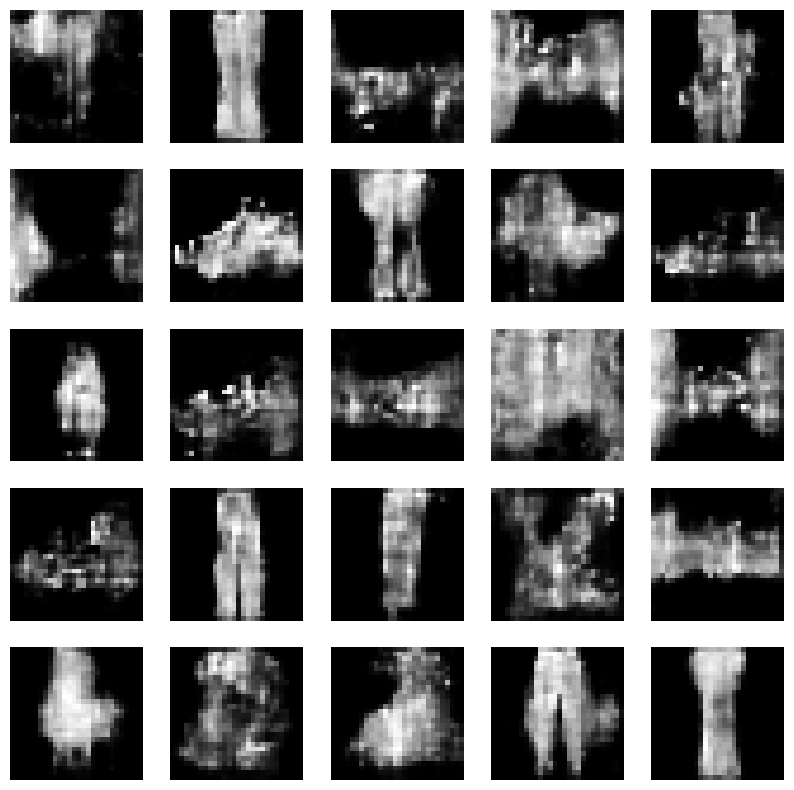

In [ ]:
plot_generated_improved_images(5)

# Сравнительный анализ моделей

* Быстрота обучения: согласно журналу обучения, эпохи классической модели занимали около 7 с, тогда как для улучшенной требовалось порядка 12 с. Классическая архитектура обучается быстрее.

* Реалистичность изображений: по всем визуальным признакам DCGAN значительно превосходит классическую GAN на датасете Fashion-MNIST: объекты одежды узнаваемы, разнообразны и содержат больше деталей, тогда как классическая архитектура практически не вышла из стадии «шумовых пятен».

* Стабильность. Потери колеблются в обеих моделях примерно одинаково.